## Handwriting classification

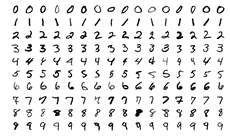

In this sample, you will create a deep neural network using Deeplearning4j and train a model capable of classifying random handwriting digits. 

This example use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.

This sample is written in Kotlin, a Java-based language that is well suited for notebooks like this one.

### What you will learn

1. Load a dataset for a neural network.
2. Format EMNIST for image recognition.
3. Create a deep neural network.
4. Train a model.
5. Evaluate the performance of your model.

In [1]:
%use deeplearning4j-cuda(cuda=10.2)

In [2]:
//number of rows and columns in the input pictures
val numRows = 28
val numColumns = 28
val outputNum = 10 // number of output classes
val batchSize = 64 // batch size for each epoch
val rngSeed = 123 // random number seed for reproducibility
val numEpochs = 5 // number of epochs to perform
val rate = 0.0015 // learning rate

In [3]:
import org.deeplearning4j.datasets.iterator.impl.MnistDataSetIterator

//Get the DataSetIterators:
val mnistTrain = MnistDataSetIterator(batchSize, true, rngSeed)
val mnistTest = MnistDataSetIterator(batchSize, false, rngSeed)

In [4]:
import org.nd4j.linalg.learning.config.Nesterovs
import org.nd4j.linalg.lossfunctions.LossFunctions.LossFunction
import org.nd4j.linalg.activations.Activation

val conf = NeuralNetConfiguration.Builder()
        .seed(rngSeed.toLong()) //include a random seed for reproducibility
         // use stochastic gradient descent as an optimization algorithm

        .activation(Activation.RELU)
        .weightInit(WeightInit.XAVIER)
        .updater(Nesterovs(rate, 0.98)) //specify the rate of change of the learning rate.
        .l2(rate * 0.005) // regularize learning model
        .list()
        .layer(DenseLayer.Builder() //create the first input layer.
                .nIn(numRows * numColumns)
                .nOut(500)
                .build())
        .layer(DenseLayer.Builder() //create the second input layer
                .nIn(500)
                .nOut(100)
                .build())
        .layer(OutputLayer.Builder(LossFunction.NEGATIVELOGLIKELIHOOD) //create hidden layer
                .activation(Activation.SOFTMAX)
                .nIn(100)
                .nOut(outputNum)
                .build())
        .build()
        
val model = MultiLayerNetwork(conf)
model.init()
println(model.summary())


LayerName (LayerType)   nIn,nOut   TotalParams   ParamsShape           
layer0 (DenseLayer)     784,500    392 500       W:{784,500}, b:{1,500}
layer1 (DenseLayer)     500,100    50 100        W:{500,100}, b:{1,100}
layer2 (OutputLayer)    100,10     1 010         W:{100,10}, b:{1,10}  
-----------------------------------------------------------------------
            Total Parameters:  443 610
        Trainable Parameters:  443 610
           Frozen Parameters:  0



### Launching Deeplearning4j UI

In [5]:
import org.deeplearning4j.ui.api.UIServer
import org.deeplearning4j.optimize.listeners.ScoreIterationListener
import org.deeplearning4j.api.storage.StatsStorageRouter
import org.deeplearning4j.api.storage.impl.RemoteUIStatsStorageRouter
import org.deeplearning4j.ui.stats.StatsListener

val uiServer: UIServer = UIServer.getInstance()
uiServer.enableRemoteListener()
//Create the remote stats storage router - this sends the results to the UI via HTTP, assuming the UI is at http://localhost:9000
val remoteUIRouter: StatsStorageRouter = RemoteUIStatsStorageRouter("http://localhost:9000")
model.setListeners(ScoreIterationListener(100), StatsListener(remoteUIRouter))

open a new tab in your browser and go to [http://localhost:9000](http://localhost:9000)

### Train model

In [6]:
model.fit(mnistTrain, numEpochs)

### Evaluate model

In [7]:
val eval: org.nd4j.evaluation.classification.Evaluation = model.evaluate(mnistTest)
println(eval.stats())



========================Evaluation Metrics========================
 # of classes:    10
 Accuracy:        0,9718
 Precision:       0,9722
 Recall:          0,9711
 F1 Score:        0,9714
Precision, recall & F1: macro-averaged (equally weighted avg. of 10 classes)


=========================Confusion Matrix=========================
    0    1    2    3    4    5    6    7    8    9
---------------------------------------------------
  967    0    0    1    1    0    4    2    2    3 | 0 = 0
    0 1123    2    1    0    0    5    1    3    0 | 1 = 1
    4    3  995    0    2    0    4   14   10    0 | 2 = 2
    0    1    2  988    0    1    0   10    6    2 | 3 = 3
    3    0    0    0  956    0    6    4    0   13 | 4 = 4
    7    1    0   19    2  825   20    1   11    6 | 5 = 5
    6    3    0    0    4    1  943    1    0    0 | 6 = 6
    0    8    5    2    0    0    0 1010    1    2 | 7 = 7
    5    0    2    6    4    1    8    7  937    4 | 8 = 8
    3    6    1    6   10    0

To stop the UI:

In [8]:
uiServer.stop()